In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
import copy

In [2]:
to_predict = 'casual'

In [3]:
df = pd.read_csv('data.csv', delimiter=",")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
df_eval = pd.read_csv('evaluation_data.csv', delimiter=",")
df_eval.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-20,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881
1,2011-01-20,1,0,1,1,0,4,1,1,0.26,0.2727,0.56,0.0000
2,2011-01-20,1,0,1,2,0,4,1,1,0.26,0.2727,0.56,0.0000
3,2011-01-20,1,0,1,3,0,4,1,1,0.26,0.2576,0.56,0.1642
4,2011-01-20,1,0,1,4,0,4,1,1,0.26,0.2576,0.56,0.1642


In [5]:
df = df.drop(columns=['dteday', 'cnt', 'registered', 'instant']).astype(float)
test = df_eval.drop(columns=['dteday']).astype(float)

In [6]:
train = df.iloc[:9500]
val = df.iloc[9500:]
# test = df.iloc[8500:]

In [7]:
X_train, y_train= train.drop(to_predict, axis=1), train[to_predict]
print(X_train.shape)

X_val, y_val = val.drop(to_predict, axis=1), val[to_predict]
print(X_val.shape)

X_test = test
print(X_test.shape)

(9500, 12)
(1386, 12)
(6493, 12)


In [8]:
f = 20 # no. of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(X_test,f) 
# test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
# for i in range(len(test_label_batch)):
#     test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
print("Batch size:", len(train_batch[0]))


Batch size: 475


In [9]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(12, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, 96)
        self.fc4 = nn.Linear(96, 192)
        self.fc5 = nn.Linear(192, 384)
        self.fc6 = nn.Linear(384, 96)
        self.fc7 = nn.Linear(96, 24)
        self.fc8 = nn.Linear(24, 1)

        self.dropout = nn.Dropout(0.20)
       
    def forward(self, x):
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        x = F.relu(self.fc8(x))

        return x

In [10]:
model = Regressor()
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001) # 0.015 87
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=15) 
total_epochs=0

In [11]:
best_model = copy.deepcopy(model)
best_val_loss = None

In [12]:
#print(model)
epochs = 1200
total_epochs+=epochs

model.train()

for e in tnrange(epochs):
    
    train_loss = 0
    val_loss_1 = 0
    val_loss_sum = 0
    
    for i in range(len(train_batch)):
        
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
    # saving best model
    val_loss_divided = val_loss_sum/len(val_batch)
    if best_val_loss is None or val_loss_divided < best_val_loss:
        best_val_loss = val_loss_divided
        best_model = copy.deepcopy(model)
        
        
    val_losses.append(val_loss_divided)    
    train_losses.append(train_loss/len(train_batch))
    
    if e % 50 == 0:
        print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_divided) 

C:\Users\user\AppData\Local\Temp\ipykernel_23392\3725779950.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for e in tnrange(epochs):


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch : 0 train_loss : 3855.151066207886 Val loss:  3298.280326461792
Epoch : 50 train_loss : 3851.567405128479 Val loss:  3294.6255001068116
Epoch : 100 train_loss : 3845.401834487915 Val loss:  3288.426413879394
Epoch : 150 train_loss : 3836.010725402832 Val loss:  3278.7596162414548
Epoch : 200 train_loss : 3819.954038619995 Val loss:  3262.306180419922
Epoch : 250 train_loss : 3795.1889446258547 Val loss:  3236.891865158081
Epoch : 300 train_loss : 3757.079154586792 Val loss:  3196.7920050811767
Epoch : 350 train_loss : 3698.845139884949 Val loss:  3139.270103759766
Epoch : 400 train_loss : 3619.242173576355 Val loss:  3056.2933082580566
Epoch : 450 train_loss : 3511.569962501526 Val loss:  2949.241816215515
Epoch : 500 train_loss : 3371.572392845154 Val loss:  2819.172200508118
Epoch : 550 train_loss : 3217.808823776245 Val loss:  2674.1563788604735
Epoch : 600 train_loss : 3050.966698074341 Val loss:  2533.928753204346
Epoch : 650 train_loss : 2888.841625213623 Val loss:  2422.04

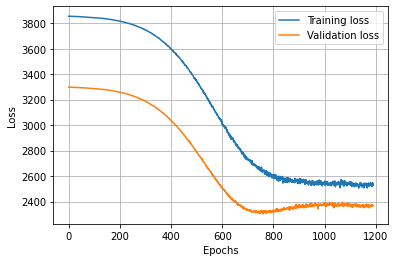

In [13]:
frm = 10 # does not 
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [14]:
# predicting for every batch
test_outputs = []
for j in range(len(test_batch)):
    test_output = model(test_batch[j])
    for value in test_output:
        test_outputs.append(value)

In [15]:
# tensor to list
list_output = []
for output in test_outputs:
    list_output.append(output.item())

len(list_output)

6493

In [16]:
# list to dataframe
df_output = pd.DataFrame(list_output)

In [17]:
# saving to file
df_output.to_csv('muchomorki.csv', header=False, index=False)

In [18]:
df_output.describe()

,0
count,6493.000000
mean,34.079273
std,14.624512
min,3.642185
25%,23.046719
50%,32.347511
75%,42.897781
max,106.514854
